## Thin plate spline

Find an interpolating surface to a set of control points with minimum bend. For image interpolation consider two such surfaces, one for each principal axis.

### References
[1] Donato, G., & Belongie, S. J. (2003). Approximation methods for thin plate spline mappings and principal warps. Department of Computer Science and Engineering, University of California, San Diego.

In [9]:
%matplotlib inline

import matplotlib as mpl

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

In [10]:
class TPS:
    def __init__(self):
        self.p = None
        
    def fit(self, c, lambd=0.):        
        n = c.shape[0]        
        U = self._u(self._d(c, c))
        K = U + np.eye(n)*lambd

        P = np.ones((n, 3))
        P[:, 1:] = c[:, :2]

        v = np.zeros(n+3)
        v[:n] = c[:, -1]

        A = np.zeros((n+3, n+3))
        A[:n, :n] = K
        A[:n, -3:] = P
        A[-3:, :n] = P.T

        self.p = np.linalg.solve(A, v) # p has structure w,a
        self.c = np.copy(c)
        
    def __call__(self, x):
        x = np.atleast_2d(x)
        U = self._u(self._d(x, self.c))
        b = np.dot(U, self.p[:-3])
        return self.p[-3] + self.p[-2]*x[:, 0] + self.p[-1]*x[:, 1] + b
        
    def _d(self, a, b):
        return np.sqrt(np.square(a[:, None, :2] - b[None, :, :2]).sum(-1))
    
    def _u(self, r):
        return r**2 * np.log(r + 1e-6)

Visualization of the fitted surface

[ 0.18033703 -0.18033703  0.18033703 -0.18033703  0.375      -0.25
 -0.25      ]


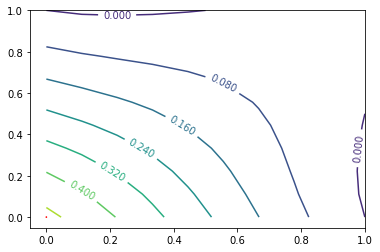

In [75]:
c = np.array([
    [0., 0, 0.5],
    [1., 0, 0.0],
    [1., 1, 0.0],
    [0, 1, 0.0],
])

tps = TPS()
tps.fit(c)
print(tps.p)

X = np.linspace(0, 1, 10)
Y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(X, Y)
xy = np.hstack((X.reshape(-1, 1),Y.reshape(-1, 1)))
Z = tps(xy).reshape(10, 10)

fig, ax = plt.subplots()
#ax.contourf(X, Y, Z)
c = ax.contour(X, Y, Z)
ax.clabel(c, inline=1, fontsize=10)
ax.scatter(tps.c[:, 0], tps.c[:, 1], tps.c[:, 2], c='r', zorder=2)


For image interpolation, we define a separate surface for x and y offsets.

In [123]:
def compute_densegrid(img, c_src, d_dst, dshape=None):
    sshape = img.shape
    if dshape is None:
        dshape = sshape
    
    delta = c_src - c_dst
    
    cx = np.column_stack((c_dst, delta[:, 0]))
    cy = np.column_stack((c_dst, delta[:, 1]))
    
    tps_x, tps_y = TPS(), TPS()
    tps_x.fit(cx)
    tps_y.fit(cy)
    
    print(tps_x.p)
    print(tps_y.p)
    
    X = np.linspace(0, 1, dshape[1]) # note: for torch this needs to be changed
    Y = np.linspace(0, 1, dshape[0])
    X, Y = np.meshgrid(X, Y)
    xy = np.hstack((X.reshape(-1, 1),Y.reshape(-1, 1)))

    map_x = (tps_x(xy).reshape(dshape[:2]) + X).astype('float32')
    map_y = (tps_y(xy).reshape(dshape[:2]) + Y).astype('float32')
    grid = np.stack((map_x, map_y), -1)
    
    return grid # H'xW'x2 grid[i,j] in range [0..1]

In [124]:
def warp_image_cv(img, c_src, c_dst, dshape=None):
    
    grid = compute_densegrid(img, c_src, c_dst, dshape)
    return cv2.remap(img, grid[:, :, 0] * img.shape[1], grid[:, :, 1] * img.shape[0], cv2.INTER_CUBIC)

In [125]:
def show_warped(img, warped):
    fig, axs = plt.subplots(1, 2, figsize=(16,8))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].imshow(img[...,::-1], origin='upper')
    axs[0].scatter(c_src[:, 0]*img.shape[1], c_src[:, 1]*img.shape[0], marker='+', color='black')
    axs[1].imshow(warped[...,::-1], origin='upper')
    axs[1].scatter(c_dst[:, 0]*warped.shape[1], c_dst[:, 1]*warped.shape[0], marker='+', color='black')
    plt.show()

[ 2.02179003e-01  2.77555756e-17 -2.02179003e-01  1.56714090e-17
 -1.01089501e+00  1.01089501e+00  7.53939805e-02 -7.53939805e-02
 -7.53939805e-02]
[ 2.02179003e-01  2.77555756e-17 -2.02179003e-01  1.56714090e-17
 -1.01089501e+00  1.01089501e+00  7.53939805e-02 -7.53939805e-02
 -7.53939805e-02]


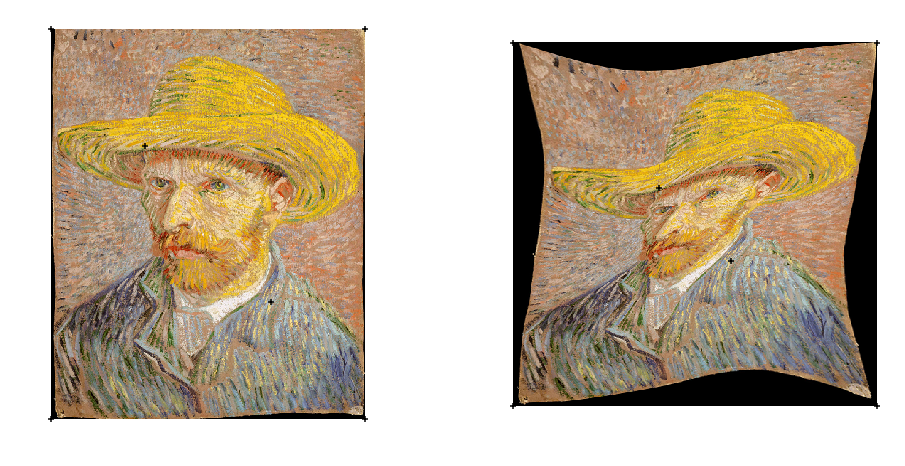

In [126]:
import cv2

img = cv2.imread('image.png')

c_src = np.array([
    [0.0, 0.0],
    [1., 0],
    [1, 1],
    [0, 1],
    [0.3, 0.3],
    [0.7, 0.7],
])

c_dst = np.array([
    [0., 0],
    [1., 0],    
    [1, 1],
    [0, 1],
    [0.4, 0.4],
    [0.6, 0.6],
])
    
warped = warp_image_cv(img, c_src, c_dst, dshape=(512, 512))
show_warped(img, warped)

Same as with OpenCV but in pytorch

In [15]:
import torch
import torch.nn.functional as F

In [16]:
def warp_image_pytorch(img, c_src, d_dst, dshape=None):
    
    grid = compute_densegrid(img, c_src, d_dst, dshape)
    grid = grid * 2 - 1 # [-1,1] range required
    
    img = torch.as_tensor(img, dtype=torch.float32).permute(2,1,0).unsqueeze(0) / 255.
    grid = torch.as_tensor(grid).unsqueeze(0)
    
    img = F.grid_sample(img, grid)
    img = (img * 255).to(torch.uint8).squeeze(0).permute(2,1,0).numpy()
    return img

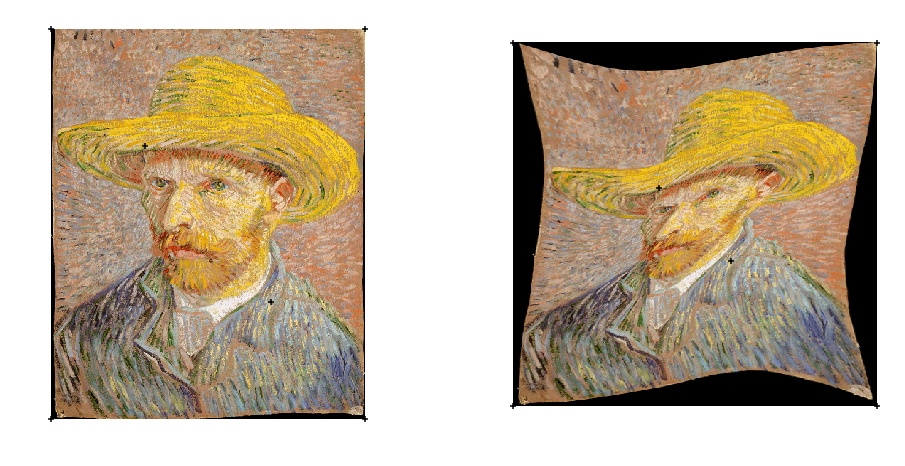

In [26]:
warped = warp_image_pytorch(img, c_src, c_dst, dshape=(512, 512))
show_warped(img, warped)

In [223]:
def tps(theta, ctrl, grid):
    '''Evaluate the thin-plate-spline (TPS) surface at xy locations arranged in a grid.
    The TPS surface is a minimum bend interpolation surface defined by a set of control points.
    The function value for a x,y location is given by
    
        TPS(x,y) := theta[-3] + theta[-2]*x + theta[-1]*y + \sum_t=0,T theta[t] U(x,y,ctrl[t])
        
    This method computes the TPS value for multiple batches over multiple grid locations for 2 
    surfaces in one go.
    
    Params
    ------
    theta: Nx(T+3)x2 tensor
        Batch size N, T+3 model parameters for T control points in dx and dy.
    ctrl: NxTx2 tensor
        T control points in normalized image coordinates [0..1]
    grid: NxHxWx3 tensor
        Grid locations to evaluate with homogeneous 1 in first coordinate.
        
    Returns
    -------
    z: NxHxWx2 tensor
        Function values at each grid location in dx and dy.
    '''
    N, H, W, _ = grid.size()
    T = ctrl.shape[1]
    
    diff = grid[...,1:].unsqueeze(-2) - ctrl.unsqueeze(1).unsqueeze(1)
    D = torch.sqrt((diff**2).sum(-1))
    U = (D**2) * torch.log(D + 1e-6)
    # U is NxHxWxT
    b = torch.bmm(U.view(N, -1, T), theta[:, :-3]).view(N,H,W,2)
    # b is NxHxWx2
    z = torch.bmm(grid.view(N,-1,3), theta[:,-3:]).view(N,H,W,2) + b
    
    return z

def tps_grid(theta, ctrl, size):
    '''Compute a thin-plate-spline grid from parameters for sampling.
    
    Params
    ------
    theta: Nx(T+3)x2 tensor
        Batch size N, T+3 model parameters for T control points in dx and dy.
    ctrl: NxTx2 tensor
        T control points in normalized image coordinates [0..1]
    size: tuple
        Output grid size as NxCxHxW. C unused. This defines the output image
        size when sampling.
    
    Returns
    -------
    grid : NxHxWx2 tensor
        Grid suitable for sampling in pytorch containing source image
        locations for each output pixel.
    '''    
    N, _, H, W = size

    grid = theta.new(N, H, W, 3)
    grid[:, :, :, 0] = 1.
    grid[:, :, :, 1] = torch.linspace(0, 1, W)
    grid[:, :, :, 2] = torch.linspace(0, 1, H).unsqueeze(-1)   
    
    z = tps(theta, ctrl, grid)
    return (grid[...,1:] + z)*2-1 # [-1,1] range required by F.sample_grid

In [224]:
c = torch.tensor([
    [0., 0],
    [1., 0],
    [1., 1],
    [0, 1],
]).unsqueeze(0)
theta = torch.zeros(1, 4+3, 2)
size= (1,1,6,3)
tps_grid(theta, c, size).shape

torch.Size([1, 6, 3, 2])

tensor(0.4360, grad_fn=<MeanBackward1>)
tensor([[-0.1492,  0.1718,  0.1793, -0.1138, -0.0074, -0.0470,  0.1338, -0.4725,
          0.0188],
        [-0.1444, -0.1598,  0.1673,  0.1424,  0.0211, -0.0077, -0.0431, -0.0361,
         -0.5523]])


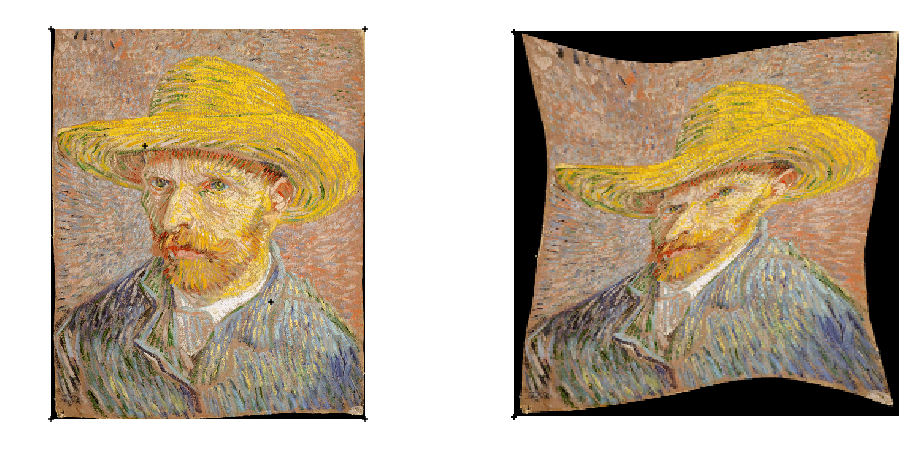

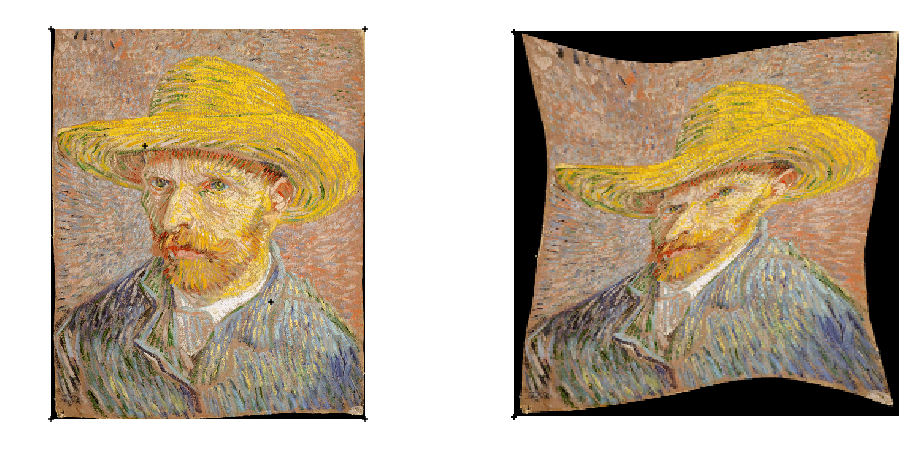

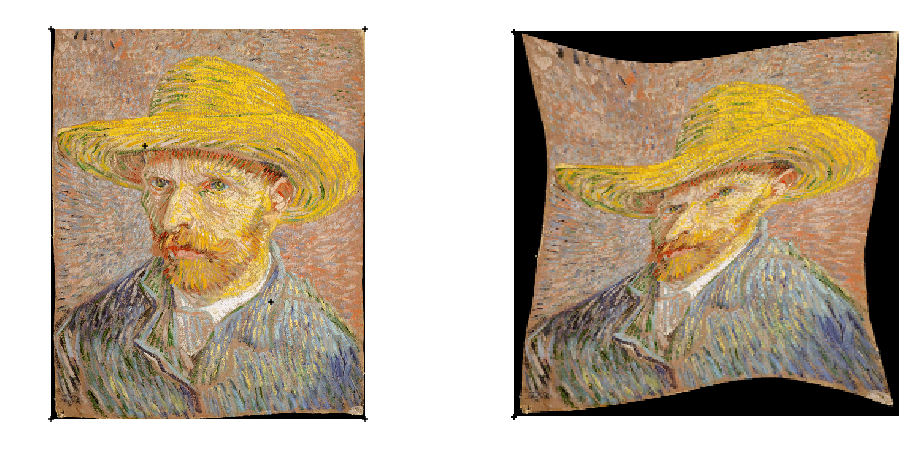

In [225]:
c_dst = torch.tensor([
    [0., 0],
    [1., 0],    
    [1, 1],
    [0, 1],
    [0.4, 0.4],
    [0.6, 0.6],
])

c_dst = c_dst.unsqueeze(0).expand(3, 6, 2)
theta = torch.tensor([
    [ 0.21,  2.77555756e-17, -2.02179003e-01,  1.56714090e-17,
 -1.01189501e+00,  1.01089501e+00,  7.53939805e-02, -7.53939805e-02,
 -7.53939805e-02],
[ 2.02179003e-01,  2.77555756e-17, -2.02179003e-01,  1.56714090e-17,
 -1.01089501e+00,  1.01089501e+00,  7.53939805e-02, -7.53939805e-02,
 -7.53939805e-02]
], requires_grad=True)

theta_rep = theta.transpose(0,1).unsqueeze(0).expand(3,9,2).contiguous()
size = (3, 3, 256, 256)

img = cv2.imread('image.png')
img = torch.as_tensor(img, dtype=torch.float32).permute(2,1,0).unsqueeze(0) / 255.
img = img.expand(3, *img.shape[1:])

grid = tps_grid(theta_rep, c_dst, size)
warped = F.grid_sample(img, grid)

loss = warped.mean()
print(loss)
loss.backward()
print(theta.grad)

warped = (warped * 255).to(torch.uint8).squeeze(0).permute(0,3,2,1).numpy()
show_warped(cv2.imread('image.png'), warped[0])
show_warped(cv2.imread('image.png'), warped[1])
show_warped(cv2.imread('image.png'), warped[2])


#grid = torch.as_tensor(grid).unsqueeze(0)
    
#img = F.grid_sample(img, grid)
#
